# Tutorial 5: Model Asssumptions and Causality

#### Lecture and Tutorial Learning Goals:
After completing this week's lecture and tutorial work, you will be able to:

1. Give an example of a real problem that aims to test a causal relationship between variables.
2. Give an example of a real problem the model can only establish an association between the response and the input variables.
3. Discuss how the desired goal of generative modelling is usually to make causal claims however we cannot often/easily do so (e.g., in particular in the context of observational studies).
4. Discuss the role of confounders in causal inference.
5. Describe heteroscedasticity and the problem it presents to generative modeling.
6. Write a computer script to assess whether heteroscedasticity in a given data set, and if so, use practical solutions to manage it.
7. Describe colinearity and the problem it presents to generative modeling.
8. Write a computer script to assess whether collinearity exists between input variables in a given data set, and if so, use practical solutions to manage it.
9. Discuss what model diagnostics the data scientist can do by themselves and when the data scientist needs to consult a domain expert.

In [1]:
# Run this cell before continuing.
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(AER)
source("tests_tutorial_05.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: lmtest

Loading required package: zoo


A

## 1. Multicollinearity in Practice

In this tutorial, we will work with the California test score data `CASchools` from the package `AER` with $n = 420$. The [package's documentation](https://rdrr.io/cran/AER/man/CASchools.html) provides the following description:

> The data used here are from all 420 K-6 and K-8 schools from different districts in California with data available for 1998 and 1999. Test scores are on the Stanford 9 standardized test administered to 5th grade students. School characteristics and demographic variables for the students are averaged across the district. 

From all the variables contained in this dataset, we will use the following:

- `district`: district code (character type).
- `english`: percentage of students in the district that are English learners, i.e., students for whom English is a second language.
- `read`: average reading score by district, which comes from a standardized test administered to 5th-grade students.
- `math`: average math score.
- `students`: total enrollment.
- `teachers`: number of teachers.
- `calworks`: percent qualifying for CalWorks (income assistance).
- `lunch`: percent qualifying for reduced-price lunch.
- `computer`: number of computers.
- `expenditure`: expenditure per student.
- `income`: district average income (in USD 1,000).
- `english`: percent of English learners.

The math and reading scores are averaged into a new variable called `score`, which will be the response variable in this analysis

The number of students and teachers are combined into a student to teacher ratio, named `stratio`

In [2]:
data(CASchools)
CASchools_dat <- CASchools %>%
  select(-c(district,school, grades, county)) %>%
  mutate_if(is.numeric, round, 2)  %>% 
  mutate(stratio = students/teachers,score=(math + read)/2)  %>% 
  select(-c(students,teachers, math , read)) 

head(CASchools_dat) 

calworks lunch computer expenditure income english stratio  score 
1  0.51     2.04  67      6384.91     22.69   0.00   17.88991 690.80
2 15.42    47.92 101      5099.38      9.82   4.58   21.52466 661.20
3 55.03    76.32 169      5501.95      8.98  30.00   18.69723 643.60
4 36.48    77.05  85      7101.83      8.98   0.00   17.35714 647.70
5 33.11    78.43 171      5235.99      9.08  13.86   18.67133 640.85
6 12.32    86.96  25      5580.15     10.41  12.41   21.40625 605.55

**Question 1.1**
<br>{points: 1}

To explore a potential problem of multicollinearity, let's start by exploring (visually) the association between all potential input variables in the dataset. 

Remove the response variable `score` and use the plotting function ggpairs(), from the library GGally, to generate pair plots of ALL the other variables in `CASchools_dat`. The ggplot() object's name will be `CASchools_pair_plots`.

*Fill out those parts indicated with ..., uncomment the corresponding code in the cell below, and run it.*

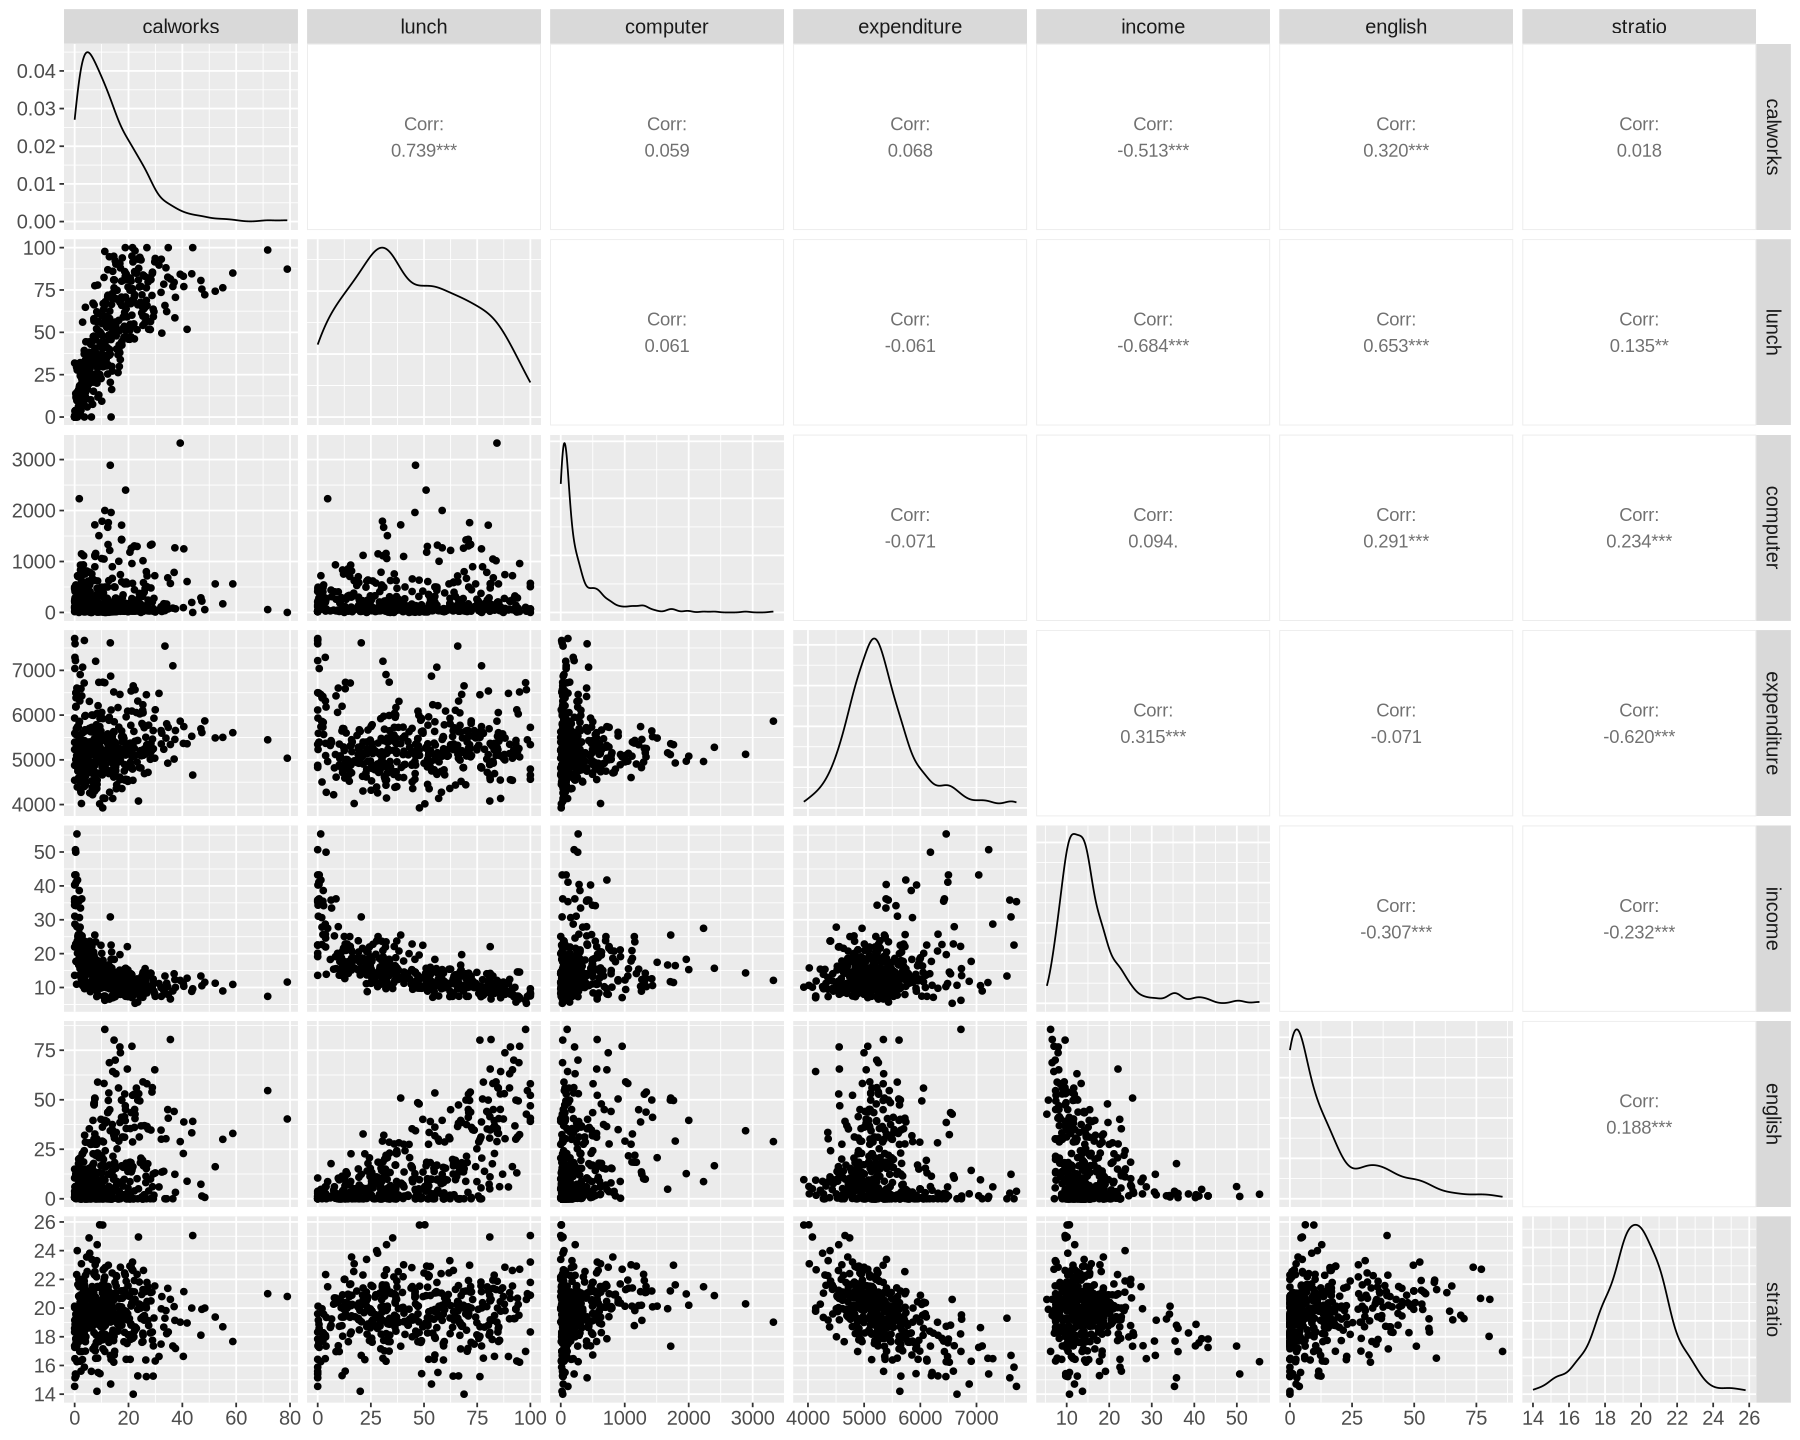

In [3]:
options(repr.plot.width = 15, repr.plot.height = 12) # Adjust these numbers so the plot looks good in your desktop.

# CASchools_pair_plots <- ... %>%
#   select(- ...) %>% 
#   ...(progress = FALSE) +
#   theme(
#     text = element_text(size = 15),
#     plot.title = element_text(face = "bold"),
#     axis.title = element_text(face = "bold")
#   )
# CASchools_pair_plots

# your code here
CASchools_pair_plots <- CASchools_dat %>%
  select(- score) %>% 
  ggpairs(progress = FALSE) +
  theme(
    text = element_text(size = 15),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  )
CASchools_pair_plots


In [4]:
test_1.1()

Test passed 🎊
Test passed 🎊
Test passed 🥇
Test passed 🎉
Test passed 🥇
Test passed 😀
[1] "Success!"


**Question 1.2**
<br>{points: 1}

Based on the pairwise plots and correlation coefficients in `CASchools_pair_plots`, do any pair of *input variables* appear to be highly positively or negatively correlated? Which ones?

Recall that a correlation coefficient equal to $1$ means a perfect positive linear association and $-1$ a perfect negative linear association. A correlation greater than 0.6 in absolute value can be considered "high".

> *Your answer goes here.*

*   The "calworks" and "lunch" variables have a correlation coefficient of 0.739, indicating a strong positive correlation.
*   The "lunch" and "income" variables have a correlation coefficient of -0.684, indicating a strong negative correlation.
*   The "lunch" and "english" variables have a correlation coefficient of 0.653, indicating a strong positive correlation.
*   The "expenditure" and "stratio" variables have a correlation coefficient of -0.620, indicating a strong negative correlation.

These pairs have correlation coefficients with absolute values greater than 0.6 and are therefore considered "high"

**Question 1.3**
<br>{points: 1}

Another way to visualize pairwise correlation coefficients between all input variables is to use a heatmap. 

Creating this visualization will require prior data wrangling of `CASchools_dat`. 

We will first create a *melted* correlation matrix with all pairwise correlations between the input variables of `CASchools_dat` and name it `corr_matrix_CASchools`. Recall to remove `score` from the dataset to visualize only the correlation between input variables.

> **Hint:** You can use the function `cor()` for this purpose.

The code below will generate a data frame called `corr_matrix_CASchools` with three columns:

- `var1`: first input variable.
- `var2`: second input variable.
- `corr`: correlation coefficient between `var1` and `var2`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [5]:
# corr_matrix_CASchools <- CASchools_dat %>%
#   select(- ...) %>% 
#   ...() %>%
#   as.data.frame() %>%
#   rownames_to_column("var1") %>%
#   pivot_longer(-var1, names_to = "var2", values_to = "corr")
# corr_matrix_CASchools

# your code here
corr_matrix_CASchools <- CASchools_dat %>%
  select(- score) %>% 
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")
corr_matrix_CASchools

var1        var2        corr       
1  calworks    calworks     1.00000000
2  calworks    lunch        0.73943011
3  calworks    computer     0.05917507
4  calworks    expenditure  0.06788960
5  calworks    income      -0.51268379
6  calworks    english      0.31957185
7  calworks    stratio      0.01826266
8  lunch       calworks     0.73943011
9  lunch       lunch        1.00000000
10 lunch       computer     0.06138096
11 lunch       expenditure -0.06103515
12 lunch       income      -0.68446362
13 lunch       english      0.65305692
14 lunch       stratio      0.13518904
15 computer    calworks     0.05917507
16 computer    lunch        0.06138096
17 computer    computer     1.00000000
18 computer    expenditure -0.07131049
19 computer    income       0.09431706
20 computer    english      0.29133723
21 computer    stratio      0.23382408
22 expenditure calworks     0.06788960
23 expenditure lunch       -0.06103515
24 expenditure computer    -0.07131049
25 expenditure expenditure  1.00000000
26 expenditure income       0.31450202
27 expenditure english     -0.07139044
28 expenditure stratio     -0.61997903
29 income      calworks    -0.51268379
30 income      lunch       -0.68446362
31 income      computer     0.09431706
32 income      expenditure  0.31450202
33 income      income       1.00000000
34 income      english     -0.30745878
35 income      stratio     -0.23223744
36 english     calworks     0.31957185
37 english     lunch        0.65305692
38 english     computer     0.29133723
39 english     expenditure -0.07139044
40 english     income      -0.30745878
41 english     english      1.00000000
42 english     stratio      0.18763956
43 stratio     calworks     0.01826266
44 stratio     lunch        0.13518904
45 stratio     computer     0.23382408
46 stratio     expenditure -0.61997903
47 stratio     income      -0.23223744
48 stratio     english      0.18763956
49 stratio     stratio      1.00000000

In [6]:
test_1.3()

Test passed 😀
Test passed 🥳
Test passed 🥇
Test passed 🎊
Test passed 🎊
[1] "Success!"


**Question 1.4**
<br>{points: 1}

To create a proper $5 \times 5$ correlation matrix on top of a heatmap using `corr_matrix_CASchools`, the function `geom_tile()` from `ggplot2` is necessary. Create a plot called `plot_corr_matrix_CASchools` with the following characteristics:

- It would have the style of a heatmap where the correlation coefficient gives the colour scale. You have to use `scale_fill_distiller()` to select the colour palette (`YlOrRd`, preferably) and adjust the correlation limits on the scale (between `-1` and `1`).
- The scale legend's title has to be indicated as **Correlation Coefficient**.
- Include the correlations from `corr_matrix_CASchools` in the corresponding matrix cells **rounded to 2 decimal places**. Use `geom_text()`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

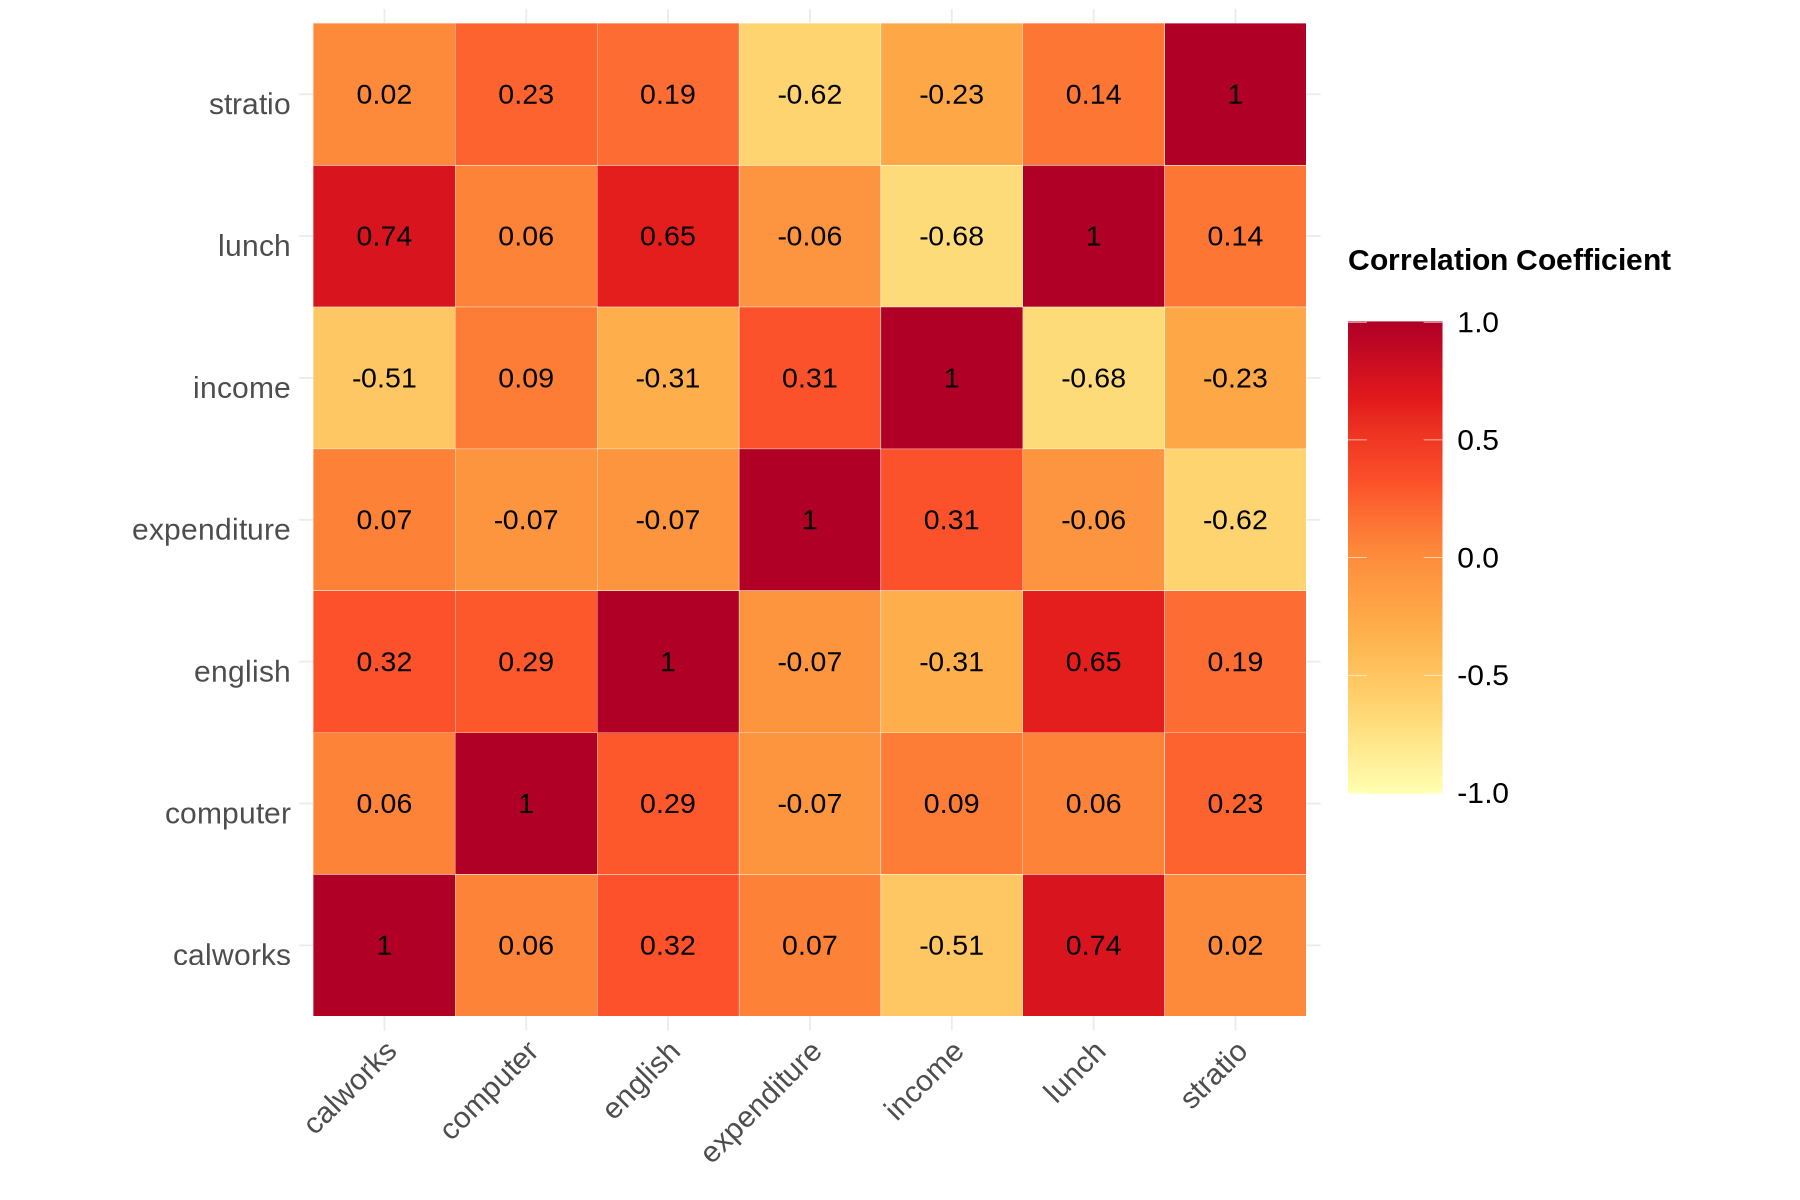

In [7]:
options(repr.plot.width = 15, repr.plot.height = 10) # Adjust these numbers so the plot looks good in your desktop.

# plot_corr_matrix_CASchools <- corr_matrix_CASchools %>%
#   ggplot(aes(..., ...)) +
#   ...(aes(fill = ...), color = "white") +
#   ...("Correlation Coefficient \n",
#     palette =  ...,
#     direction = 1, limits = ...
#   ) +
#   labs(x = "", y = "") +
#   theme_minimal() +
#   theme(
#     axis.text.x = element_text(
#       angle = 45, vjust = 1,
#       size = 18, hjust = 1
#     ),
#     axis.text.y = element_text(
#       vjust = 1,
#       size = 18, hjust = 1
#     ),
#     legend.title = element_text(size = 18, face = "bold"),
#     legend.text = element_text(size = 18),
#     legend.key.size = unit(2, "cm")
#   ) +
#   coord_fixed() +
#   geom_text(aes(..., ..., label = round(..., ...)), color = "black", size = 6)
# plot_corr_matrix_CASchools

# your code here
plot_corr_matrix_CASchools <- corr_matrix_CASchools %>%
  ggplot(aes(var1, var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
    palette =  "YlOrRd",
    direction = 1, limits = c(-1, 1)
  ) +
  labs(x = "", y = "") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 18, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 18, hjust = 1
    ),
    legend.title = element_text(size = 18, face = "bold"),
    legend.text = element_text(size = 18),
    legend.key.size = unit(2, "cm")
  ) +
  coord_fixed() +
  geom_text(aes(var1, var2, label = round(corr, 2)), color = "black", size = 6)
plot_corr_matrix_CASchools

In [8]:
test_1.4()

Test passed 😸
Test passed 🌈
Test passed 😸
Test passed 🎉
Test passed 🌈
Test passed 🌈
Test passed 🥳
[1] "Success!"


**Question 1.5**
<br>{points: 1}
Let's examine how the multicollinearity problem affects the least squares estimators. Using `CASchools_dat`, estimate an MLR called `MLR_CASchools` relating the response `score` to all the input variables selected.

*Tip*: in `lm`, you can use `.` at the RHS to avoid typing all input variables

> lm(response ~ ., data)

Obtain the estimated coefficients, SEs, statistics and $p$-values using `tidy()`. Store the results in `MLR_CASchools_results`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [9]:
# MLR_CASchools <- ...(..., ...)

# MLR_CASchools_results <- ...(...) %>% mutate_if(is.numeric, round, 2)
# MLR_CASchools_results

# your code here
MLR_CASchools <- lm(score ~., data = CASchools_dat)

MLR_CASchools_results <- tidy(MLR_CASchools) %>% mutate_if(is.numeric, round, 2)
MLR_CASchools_results

term        estimate std.error statistic p.value
1 (Intercept) 661.88   9.07       72.98    0.00   
2 calworks     -0.09   0.06       -1.59    0.11   
3 lunch        -0.37   0.04      -10.24    0.00   
4 computer      0.00   0.00        0.40    0.69   
5 expenditure   0.00   0.00        1.97    0.05   
6 income        0.62   0.09        6.95    0.00   
7 english      -0.21   0.03       -6.13    0.00   
8 stratio      -0.28   0.29       -0.97    0.33

In [10]:
test_1.5()

Test passed 🥳
Test passed 🌈
Test passed 😀
Test passed 🥇
Test passed 🎉
Test passed 🥳
Test passed 🌈
Test passed 🥳
[1] "Success!"


**Question 1.6**
<br>{points: 1}

Some of the input variables are highly correlated and will be a problem for the least square estimates of the regression coefficients and their standard errors. A problem known as *multicollinearity*.

We can use the Variance Inflation Factor (VIF) to help quantify multicollinearity in a dataset. VIF ranges from $1$ (no multicollinearity) to infinity. The smallest the VIF, the lower the sign of multicollinearity. 

Calculate the VIF for your model `MLR_CASchools`. Assign the results to an object `VIF_MLR_CASchools`.

> **Hint:** A `vif()` function is available as part of the `car` package.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [11]:
# VIF_MLR_CASchools <- ...(...)
# round(VIF_MLR_CASchools, 3)

# your code here
VIF_MLR_CASchools <- vif(MLR_CASchools)
round(VIF_MLR_CASchools, 3)

calworks       lunch    computer expenditure      income     english 
      2.588       5.710       1.238       1.862       2.445       2.347 
    stratio 
      1.756

In [12]:
test_1.6()

Test passed 🥳
Test passed 🌈
[1] "Success!"


**Question 1.7**
<br>{points: 1}

Based on the VIF results in `VIF_MLR_CASchools`, answer the following questions:

**1.7.0.** Select the top-2 variables with the highest VIFs?

**A.** `calworks`.

**B.** `lunch`.

**C.** `computer`.

**D.** `expenditure`.

**E.** `income`.

**F.** `english`.

**G.** `stratio`.

*Assign your answer to the object `answer1.7.0`. Your answer must be a single string indicating the correct options **in alphabetical order** and surrounded by quotes (e.g., `"FG"` indicates you are selecting these two options).*

**1.7.1.** Does this pair also have the highest absolute correlation from all the pairwise correlations shown in the heatmap `plot_corr_matrix_CASchools`?

**A.** Yes.

**B.** No.

*Assign your answer to an object called `answer1.7.1`. Your answer should be a single character surrounded by quotes.*


In [13]:
# answer1.7.0 <- ...
# answer1.7.1 <- ...

# your code here
answer1.7.0 <- "AB"
answer1.7.1 <- "A"


In [14]:
test_1.7.0()
test_1.7.1()

Test passed 🥳
Test passed 😸
Test passed 🥳
[1] "Success!"
Test passed 🌈
Test passed 🎊
Test passed 🎉
[1] "Success!"


**Question 1.8**
<br>{points: 1}

One way to deal with multicollinearity is dropping those input variables associated with the largest VIFs and pairwise correlation coefficients. We now estimate a reduced MLR using only a subset of the input variables in `CASchools_dat`, call it `red_MLR_CASchools`, as follows:

- From the pair of input variables with the highest absolute correlation (positive or negative) in `plot_corr_matrix_CASchools`, only use the one with the smallest VIF found in `VIF_MLR_CASchools`.
- Add **the rest** of input variables found in `CASchools_dat`.

Hence, `red_MLR_CASchools` will have four input variables. Use `tidy()` to summarize results in `red_MLR_CASchools_results`

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [15]:
# red_MLR_CASchools <- CASchools_dat  %>% select(-...) %>% 
#                        ...(..., data = .)

# red_MLR_CASchools_results <- ...(...) %>% mutate_if(is.numeric, round, 2)
# red_MLR_CASchools_results

# your code here
red_MLR_CASchools <- CASchools_dat  %>% select(-lunch) %>% 
                       lm(score ~ ., data = .)

red_MLR_CASchools_results <- tidy(red_MLR_CASchools) %>% mutate_if(is.numeric, round, 2)
red_MLR_CASchools_results

term        estimate std.error statistic p.value
1 (Intercept) 652.05   10.09      64.64    0.00   
2 calworks     -0.47    0.05      -9.33    0.00   
3 computer      0.00    0.00       1.46    0.14   
4 expenditure   0.00    0.00       0.93    0.35   
5 income        1.10    0.08      12.90    0.00   
6 english      -0.45    0.03     -15.63    0.00   
7 stratio      -0.35    0.32      -1.08    0.28

In [16]:
test_1.8()

Test passed 🌈
Test passed 😀
Test passed 😀
Test passed 🎉
Test passed 🥳
Test passed 🥳
Test passed 🥇
Test passed 😀
[1] "Success!"


**Question 1.9**
<br>{points: 1}

Compare the results of `MLR_CASchools_results` with those of `red_MLR_CASchools_results`. Comment on how the estimates and $p$-values for the coefficients of the remaining input variables have changed after removing a highly correlated variable from the data.

> *Your answer goes here.*

Comparing these two results, I observe that adjustments were made to certain variables following a Variance Inflation Factor (VIF) analysis to reduce multicollinearity. The estimate for calworks changed from -0.09 to -0.47, with the p-value significantly decreasing from 0.11 to 0.00. The estimate for income increased from 0.62 to 1.10, and the estimate for english changed from -0.21 to -0.45, both showing statistically significant changes. Moreover, the p-value for the computer variable decreases from 0.69 to 0.14, though it states not statistically significant. These changes reflect the results of reducing multicollinearity by VIF, indicating that the removal of the lunch variable impacted the estimates and statistical significance of the other variables.

**Question 1.10**
<br>{points: 1}

Now, obtain the VIFs with `red_MLR_CASchools`. Assign the results to an object `VIF_red_MLR_CASchools`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [17]:
# VIF_red_MLR_CASchools <- ...(...)
# round(VIF_red_MLR_CASchools, 3)

# your code here
VIF_red_MLR_CASchools <- vif(red_MLR_CASchools)
round(VIF_red_MLR_CASchools, 3)

calworks    computer expenditure      income     english     stratio 
      1.550       1.220       1.846       1.777       1.296       1.755

In [18]:
test_1.10()

Test passed 😀
Test passed 🎊
[1] "Success!"


**Question 1.11**
<br>{points: 1}

James et al. (2013) in [*An Introduction to Statistical Learning*](https://www.statlearning.com/) (see Section 3.3.3 in Subsection Collinearity) indicate that, as a rule of thumb, a VIF value that exceeds 5 or 10 is an indicator of a  multicollinearity problem. 

Comparing the results of `VIF_MLR_CASchools` with those of `VIF_red_MLR_CASchools`, and following this recommendation, do you think that excluding the variable with the largest VIF in `VIF_MLR_CASchools` solved the multicollinearity issue? 

**A.** Yes.

**B.** No.

*Assign your answer to an object called `answer1.11`. Your answer should be a single character surrounded by quotes.*

In [19]:
# answer1.11 <- ...

# your code here
answer1.11 <- "A"

In [20]:
test_1.11()

Test passed 🎉
Test passed 😸
Test passed 🥳
[1] "Success!"


## 2.  Causality and Confounders

In this section we will explore the problem of confounders in causal inference using a simulation. 

Roughly speaking, in a framework where $X$ is the input variable and $Y$ is the response, another input variable $C$ confounds the $X$-$Y$ relationship if $C$ and $X$ are associated, and $C$ and $Y$ are associated. 

Let us retake the example from `worksheet_01` and `tutorial_01` of an A/B testing involving two versions of a TikTok ad:

- Suppose a sport company's marketing team has developed a new video for their TikTok ad. They want to know if this **new** ad will **increase** the ad engagement (which they will measure via the *ad dwell time* in seconds, i.e., a continuous response) compared to the **current** ad they are running in a given customer population.
- Furthermore, let us make the framework more complex. Suppose that athletes in this population have larger dwell times and are more interested to innovations by the company. 

**Question 2.0**
<br>{points: 1}

Under this framework, what is the response $Y$?

**A.** Type of TikTok ad.

**B.** Ad dwell time.

**C.** Athlete (yes/no).

*Assign your answer to the object `answer2.0`. Your answer should be one of `"A"`, `"B"`, or `"C"` surrounded by quotes.*

In [21]:
# answer2.0 <- 

# your code here
answer2.0 <- "B"

In [22]:
test_2.0()

Test passed 🥇
Test passed 🎉
Test passed 🥳
[1] "Success!"


**Question 2.1**
<br>{points: 1}

What is the main input of interest $X$?

**A.** Type of TikTok ad.

**B.** Ad dwell time.

**C.** Athlete (yes/no).

*Assign your answer to the object `answer2.1`. Your answer should be one of `"A"`, `"B"`, or `"C"` surrounded by quotes.*

In [23]:
# answer2.1 <- 

# your code here
answer2.1 <- "A"

In [24]:
test_2.1()

Test passed 🎉
Test passed 🌈
Test passed 🎉
[1] "Success!"


**Question 2.2**
<br>{points: 1}

True or False?

If we regress the dwell time on the type of add, ignoring which customers are athletes, the results of the estimation may be counfounded.

*Assign your answer to an object called `answer2.2`. Your answer should be either "true" or "false", surrounded by quotes.*

In [25]:
# answer2.2 <- 

# your code here
answer2.2 <- "true"

In [26]:
test_2.2()

Test passed 🥇
Test passed 🌈
Test passed 🥇
[1] "Success!"


There is more than one way to deal with confounding factors if we want to detect a causal relationship between $X$ and $Y$. Depending on the nature of the study, one could do the following:

1. In the case of observational studies, stratification is a good strategy. It implies checking the association between $X$ and $Y$ within subgroups of observations that share common values for the confounder(s). 
2. In an experimental study, such as A/B testing, we would randomize each subject to a particular value of $X$. Then, we compare $Y$ across the different groups of $X$. 

> **Heads-up:** The second strategy is the golden standard in causal inference. Nonetheless, it is not always practical or even ***ETHICAL*** to randomly assign experimental units to experimental groups.

**Question 2.3**
<br>{points: 1}

We will start by building a synthetic population for the TikTok ad case. Suppose this population has `1000000` customers (`pop.size`), where 50% are athletes and another 50% are not (i.e., a categorical variable called `athlete` with levels "Y" and "N"). 

Build a tibble containing all the customers in the population called `pop.pool` with a column for `athlete`. The values in this column needs to be simulated, as explained above. Input the count of `Y` values in `pop.pool` into the variable `pop.pool.Y` to record the number of athlets in the population.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [27]:
set.seed(123) # DO NOT CHANGE!

# pop.size <- ...

# pop.pool <- tibble(
#   athlete = sample(c(rep("Y", ...), rep("N", ...))),
# )
# head(pop.pool)
# pop.pool.Y <- sum(...)

# your code here
pop.size <- 1000000

pop.pool <- tibble(
  athlete = sample(c(rep("Y", pop.size / 2), rep("N", pop.size / 2))),
)
head(pop.pool)

pop.pool.Y <- sum(pop.pool$athlete == "Y")
pop.pool.Y



athlete
1 N      
2 Y      
3 Y      
4 Y      
5 N      
6 Y

[1] 500000

In [28]:
test_2.3()

Test passed 🥇
Test passed 🥇
Test passed 😸
[1] "Success!"


**Question 2.4**
<br>{points: 1}
 
Once we have our population pool of customers, we need to simulate their corresponding dwell times $Y$ under 2 scenarios: assuming they watch the current ad and assuming they watch the new ad. Hence, each customer in the population will have a pair of "potential" responses. *We will later assign only one of these to each customer.*

Within the population, both responses will be generated from a distribution with different means. Note that you are in control of the data generating process and, by design, there is a difference in the means of the different groups.

In [29]:
# Run this cell before continuing.

mean_current_ad <- 15 + 5 * (pop.pool$athlete == "Y")
round(head(mean_current_ad), 4)

mean_new_ad <- mean_current_ad + 8
round(head(mean_new_ad), 4)

[1] 15 20 20 20 15 20

[1] 23 28 28 28 23 28

The code above is generating the mean of each customers' response (in seconds) within `pop.pool`, according to their sport experience (athlete vs non-athlete):

- `mean_current_ad`: This is the vector of `1000000` response means corresponding to customers watching the current video. It has a baseline of `15` seconds for each customer, plus `5` additional seconds if the customer is an athlete.

- `mean_new_ad`: This is the vector of `1000000` response means corresponding to customers watching the new video. It is just the vector `mean_current_ad` plus `8` seconds for *all* the customers. 

> **Note that the value of `8` in `mean_new_ad` is the one we aim to estimate, which indicates that the new ad increases the dwell time by 8 seconds in the customer population.**

Once we have these vectors of means, we can simulate the response variables `y_current_ad` and `y_new_ad` and incorporate them in `pop.pool` as two new columns. We will use the Normal distribution to generate these responses. 

In the code below, use `rnorm()` with means `mean_current_ad` and `mean_new_ad` and fixed standard deviations of 1 second to generate values of `y_current_ad` and `y_new_ad`, respectively.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [30]:
set.seed(123) # DO NOT CHANGE!

# pop.pool$y_current_ad <- ...(..., ..., ...)
# pop.pool$y_new_ad <- ...(..., ..., ...)
# head(pop.pool)

# your code here
pop.pool$y_current_ad <- rnorm(n = nrow(pop.pool), mean = mean_current_ad, sd = 1)
pop.pool$y_new_ad <- rnorm(n = nrow(pop.pool), mean = mean_new_ad, sd = 1)
head(pop.pool)

athlete y_current_ad y_new_ad
1 N       14.43952     21.99193
2 Y       19.76982     29.35494
3 Y       21.55871     27.53103
4 Y       20.07051     29.46819
5 N       15.12929     23.44256
6 Y       21.71506     28.14620

In [31]:
test_2.4()

Test passed 😀
Test passed 🌈
Test passed 🎊
Test passed 🥇
Test passed 🌈
Test passed 🥳
[1] "Success!"


**Question 2.5**
<br>{points: 1}

Now that we have all the values from the populations of interest, we can generate a sample with the characteristics of an observational study. That is, we simulate a situation in which each customer chooses the type of ad to be seen, instead of being randomly assigned by the experimental designer.

Run the following cell to create a factor-type column called `x_self_choice` from a binomial distribution whose probability of success (in our case, "choosing the new ad") increases when the customer is an athlete (check argument `prob` in `rbinon()`). 

> Note that the factor levels in `x_self_choice` are labeled as `Current` for `0` and `New` for `1`.

In [32]:
# Run this cell before continuing.

set.seed(123)

pop.pool$x_self_choice <- factor(rbinom(pop.size,
  size = 1,
  prob = 0.5 + 0.3 * (pop.pool$athlete == "Y")), labels = c("Current", "New"))
head(pop.pool)

athlete y_current_ad y_new_ad x_self_choice
1 N       14.43952     21.99193 Current      
2 Y       19.76982     29.35494 New          
3 Y       21.55871     27.53103 New          
4 Y       20.07051     29.46819 Current      
5 N       15.12929     23.44256 New          
6 Y       21.71506     28.14620 New

### Observational data

We will now use all the information collected in `pop.pool` to create a new variable, `y_obs`, which will contain the *actual observed* response by each customer based on `x_self_choice`. In other words:

**IF** the customer is more likely to choose the `New` ad then the column `y_obs` will contain the value indicated in `y_new_ad`, **ELSE** otherwise. 

Then, from `pop.pool`, use the function `rep_sample_n()` to collect one sample of size `1000` and call it `sample_TikTok`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [33]:
set.seed(123) # DO NOT CHANGE!

# pop.pool$y_obs <- ...(...,
#   ..., ...
# )

# sample_obs_study <- ...(pop.pool, ...)
# head(sample_obs_study)

# your code here
pop.pool$y_obs <- ifelse(pop.pool$x_self_choice == "New", 
  pop.pool$y_new_ad, pop.pool$y_current_ad
)

sample_TikTok <- rep_sample_n(pop.pool, size = 1000)
head(sample_TikTok)

replicate athlete y_current_ad y_new_ad x_self_choice y_obs   
1 1         N       14.21345     21.85238 Current       14.21345
2 1         Y       21.91414     26.81990 New           26.81990
3 1         Y       20.42341     27.97019 New           27.97019
4 1         Y       20.37083     28.14515 New           28.14515
5 1         N       13.83696     22.93236 New           22.93236
6 1         N       15.05390     23.28653 Current       15.05390

In [34]:
test_2.5()

Test passed 😀
Test passed 🥳
Test passed 🥳
Test passed 🥳
Test passed 😸
Test passed 🎊
[1] "Success!"


**Question 2.6**
<br>{points: 1}

We need to graphically compare the observed distributions and spread in both ads within `sample_TikTok` via side-by-side boxplots. The `ggplot()` object's name will be `obs_dwell_time_boxplots`. Note that function `stat_summary()` will need to add the treatment means as points on top of each boxplot.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

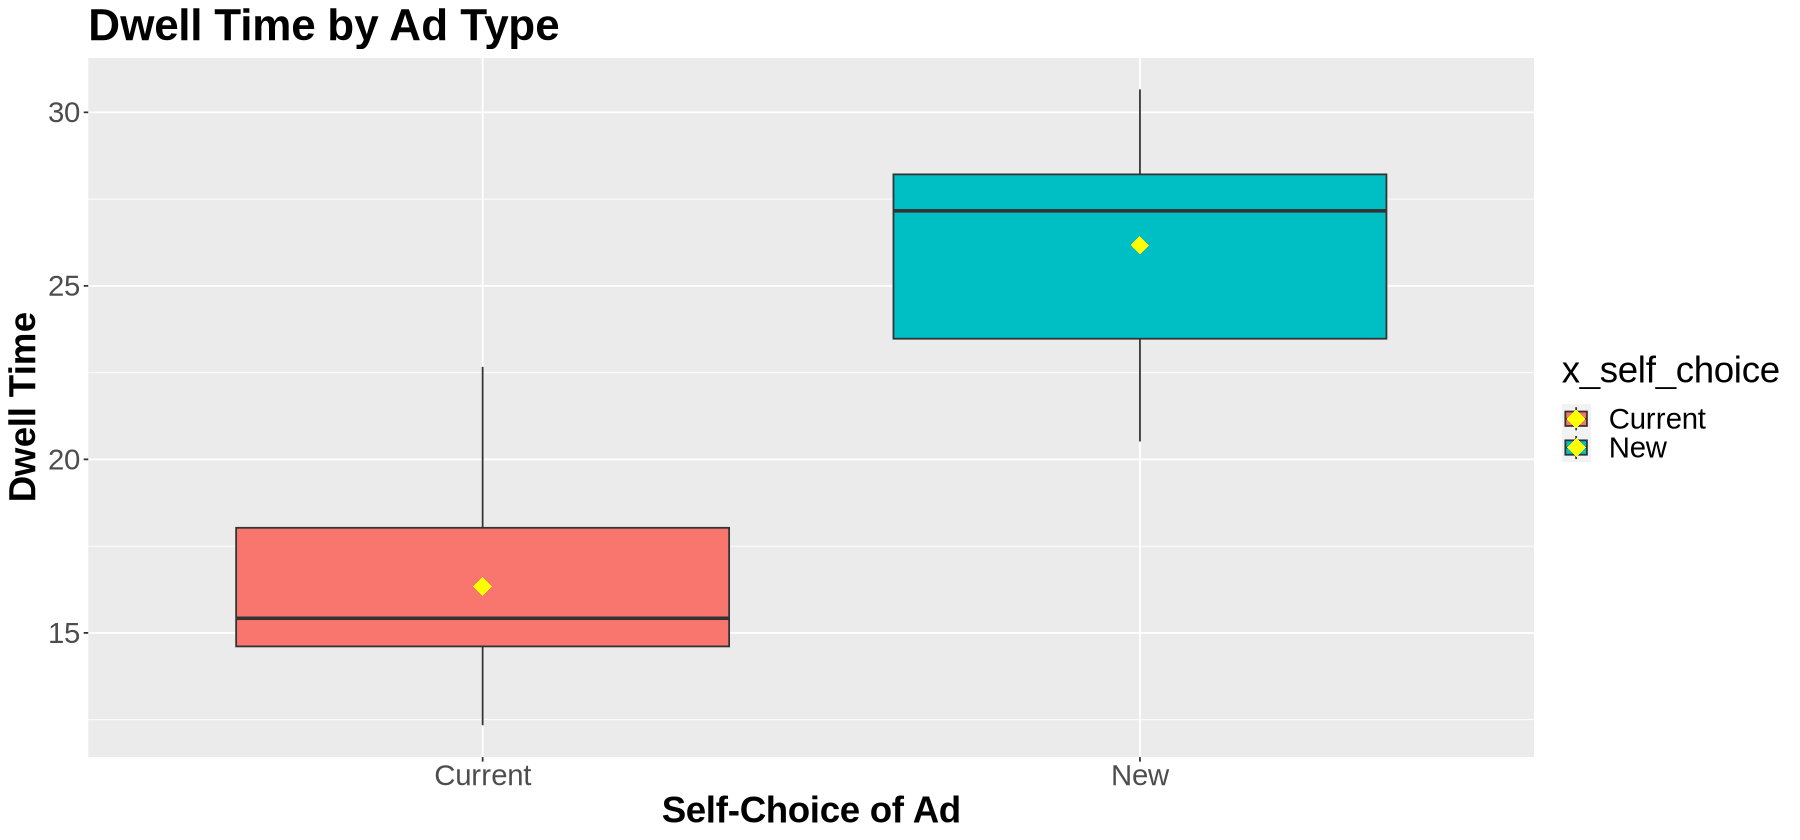

In [35]:
options(repr.plot.width = 15, repr.plot.height = 7) # Adjust these numbers so the plot looks good in your desktop.

# obs_dwell_time_boxplots <- ... %>%
#   ggplot() +
#   ...(aes(..., ..., fill = ...)) +
#   theme(
#     text = element_text(size = 22),
#     plot.title = element_text(face = "bold"),
#     axis.title = element_text(face = "bold")
#   ) +
#   ggtitle(...) +
#   xlab(...) +
#   ylab(...) +
#   stat_summary(aes(..., ..., fill = ...),
#     fun = ..., colour = "yellow", geom = "point",
#     shape = 18, size = 5
#   )
# obs_dwell_time_boxplots

# your code here
obs_dwell_time_boxplots <- sample_TikTok %>%
  ggplot() +
  geom_boxplot(aes(x_self_choice, y_obs, fill = x_self_choice)) +
  theme(
    text = element_text(size = 22),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) +
  ggtitle("Dwell Time by Ad Type") +
  xlab("Self-Choice of Ad") +
  ylab("Dwell Time") +
  stat_summary(aes(x_self_choice, y_obs, fill = x_self_choice),
    fun = mean, colour = "yellow", geom = "point",
    shape = 18, size = 5
  )
obs_dwell_time_boxplots

In [36]:
test_2.6()

Test passed 🎉
Test passed 😸
Test passed 🥇
Test passed 😀
Test passed 🎊
Test passed 🎉
Test passed 😸
Test passed 🥳
[1] "Success!"


**Question 2.7**
<br>{points: 1}

**Confounding**: in this question we will analyze the data collected in an observational study from `sample_TikTok` ignoring the variable `athlete`.

Imagine that we only collect the dwell times and the type of chosen ad, but we **don't know** if the custormer is an athlete. 

Suppose you want to estimate the **real population effect** in the dwell time of the new ad compared to that of the current ad. Recall we set up our synthetic data in such a way this effect is an increase of 8 seconds.

Using `sample_TikTok`, estimate a linear regression called `conf_obs_study_TikTok` of the dwell time (`y_obs`) versus the chosen type of ad (`x_self_choice`). 

Report the estimated coefficients, their standard errors, and corresponding $p$-values using `tidy()`. Include the corresponding asymptotic 95% confidence intervals. Store the results in the variable `conf_obs_study_TikTok_results`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [37]:
# conf_obs_study_TikTok <- ...(...,
#   ...
# )
# conf_obs_study_TikTok

# conf_obs_study_TikTok_results <- ...(..., ...) %>% mutate_if(is.numeric, round, 2)
# conf_obs_study_TikTok_results

# your code here
conf_obs_study_TikTok <- lm(y_obs ~ x_self_choice,
  data = sample_TikTok
)
conf_obs_study_TikTok

conf_obs_study_TikTok_results <- tidy(conf_obs_study_TikTok, conf.int = 0.95) %>% mutate_if(is.numeric, round, 2)
conf_obs_study_TikTok_results


Call:
lm(formula = y_obs ~ x_self_choice, data = sample_TikTok)

Coefficients:
     (Intercept)  x_self_choiceNew  
          16.330             9.834  


term             estimate std.error statistic p.value conf.low conf.high
1 (Intercept)      16.33    0.14      119.32    0       16.06    16.60    
2 x_self_choiceNew  9.83    0.17       58.42    0        9.50    10.16

In [38]:
test_2.7()

Test passed 🥇
Test passed 😀
Test passed 🎉
Test passed 🎊
Test passed 😸
Test passed 🥳
Test passed 🌈
Test passed 😀
Test passed 😀
Test passed 😸
[1] "Success!"


**Question 2.8**
<br>{points: 1}

Based on your output in `conf_obs_study_TikTok_results`, what can we conclude on the estimation of the population effect of the new ad?

**A.** The estimated effect in dwell time when switching from the current to the new ad increases by 9.83 seconds. The effect is largely overestimated in this analysis.

**B.** The estimated effect in dwell time when switching from the current to the new ad increases by 9.83 seconds. The effect is largely underestimated in this analysis.

**C.** The estimated effect in dwell time when switching from the new to the current ad increases by 9.83 seconds. The effect is largely overestimated in this analysis.

**D.** The estimated effect in dwell time when switching from the new to the current ad increases by 9.83 seconds. The effect is largely underestimated in this analysis.

*Assign your answer to an object called `answer2.8`. Your answer should be one of `"A"`, `"B"`, `"C"`, or `"D"` surrounded by quotes.*

In [39]:
# answer2.8 <- 

# your code here
answer2.8 <- "A"

In [40]:
test_2.8()

Test passed 🥳
Test passed 😀
Test passed 🎉
[1] "Success!"


**Question 2.9**
<br>{points: 1}

Now, let us suppose we can collect additional information about the customers. In particular, we add information about the sport experience of the custormers contained in the variable `athlete` in `sample_TikTok`.

Estimate a MLR called `MLR_obs_study_TikTok` of the dwell time (`y_obs`) versus the type of ad and the respective confounders. Report the estimated coefficients, their standard errors, and corresponding $p$-values using `tidy()`. Include the corresponding asymptotic 95% confidence intervals. Store the results in the variable `MLR_obs_study_TikTok_results`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [41]:
# MLR_obs_study_TikTok <- ...(...,
#   ...
# )
# MLR_obs_study_TikTok

# MLR_obs_study_TikTok_results <- ...(..., ...) %>% mutate_if(is.numeric, round, 2)
# MLR_obs_study_TikTok_results

# your code here
MLR_obs_study_TikTok <- lm(y_obs ~ athlete + x_self_choice,
  data = sample_TikTok
)
MLR_obs_study_TikTok

MLR_obs_study_TikTok_results <- tidy(MLR_obs_study_TikTok, conf.int = 0.95) %>% mutate_if(is.numeric, round, 2)
MLR_obs_study_TikTok_results


Call:
lm(formula = y_obs ~ athlete + x_self_choice, data = sample_TikTok)

Coefficients:
     (Intercept)          athleteY  x_self_choiceNew  
          15.048             4.938             7.919  


term             estimate std.error statistic p.value conf.low conf.high
1 (Intercept)      15.05    0.06      254.44    0       14.93    15.16    
2 athleteY          4.94    0.07       70.09    0        4.80     5.08    
3 x_self_choiceNew  7.92    0.07      106.46    0        7.77     8.06

In [42]:
test_2.9()

Test passed 🥳
Test passed 😸
Test passed 🥳
Test passed 🎉
Test passed 🎉
Test passed 🎊
Test passed 🎉
Test passed 🌈
Test passed 🌈
Test passed 🥳
[1] "Success!"


**Question 2.10**
<br>{points: 1}

Based on your output in `MLR_obs_study_TikTok_results`, how does the estimation of the effect of the new ad change when the confounder is included in the model?

> *Your answer goes here.*

When the variable of athlete and x_self_choice are included in the model to estimate the effect of the new ad, I can see that the coefficient estimate for athlete is 4.94, indicating that customers who are athletes tend to spend more time on the ad, and the coefficient estimate for x_self_choiceNew is 7.92, indicating that customers who choose the new ad also tend to spend more time on it. Both variables show statistically significant results, demostrating that the effect of the new ad becomes more apparent.

#### <font color="blue"> In observational studies, ommiting a confounding factor affects the estimates of the regression and causality can not be established. </font>

Including the confounder in the regression solves the problem. However, confounding variables are not always easy to collect. 

### Experimental data

**Question 2.11**
<br>{points: 1}

Finally, let us imagine we are able to run an experimental study (i.e., A/B testing) in which customers from the `sample_TikTok` are randomly assigned an add using **a balanced design**. 

To simulate this case, create a two-level factor-type column called `x_randomized` by randomly assigning each customer to view either the `Current` ad or the `New` ad. 

Then, create another column in `sample_TikTok` called `y_exp`, which will contain the obtained experimental response based on the add assigned by `x_randomized`. In other words: 

**IF** the customer is assigned to `New` then the column `y_exp` will contain the value indicated in `y_new_ad`, **ELSE** otherwise.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [43]:
set.seed(1234) # DO NOT CHANGE!

# sample_TikTok$x_randomized <- ...(c(
#   rep("Current", ...),
#   rep("New", ...)
# ))
# sample_TikTok$y_exp <- ...(...,
#   ...
# )
# head(sample_TikTok)

# your code here
sample_TikTok$x_randomized <- sample(c(
  rep("Current", nrow(sample_TikTok)/2),
  rep("New", nrow(sample_TikTok)/2)
))
sample_TikTok$y_exp <- ifelse(sample_TikTok$x_randomized == "New",
  sample_TikTok$y_new_ad, sample_TikTok$y_current_ad
)
head(sample_TikTok)

replicate athlete y_current_ad y_new_ad x_self_choice y_obs    x_randomized
1 1         N       14.21345     21.85238 Current       14.21345 Current     
2 1         Y       21.91414     26.81990 New           26.81990 New         
3 1         Y       20.42341     27.97019 New           27.97019 New         
4 1         Y       20.37083     28.14515 New           28.14515 Current     
5 1         N       13.83696     22.93236 New           22.93236 New         
6 1         N       15.05390     23.28653 Current       15.05390 New         
  y_exp   
1 14.21345
2 26.81990
3 27.97019
4 20.37083
5 22.93236
6 23.28653

In [44]:
test_2.11()

Test passed 😸
Test passed 🌈
Test passed 🥳
Test passed 🥳
Test passed 🌈
[1] "Success!"


**Question 2.12**
<br>{points: 1}

As before, let's graphically compare the experimental distributions and spread in both ads within `sample_TikTok` via side-by-side boxplots. 

The `ggplot()` object's name will be `exp_dwell_time_boxplots`. Note that function `stat_summary()` will need to add the treatment means as points on top of each boxplot.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

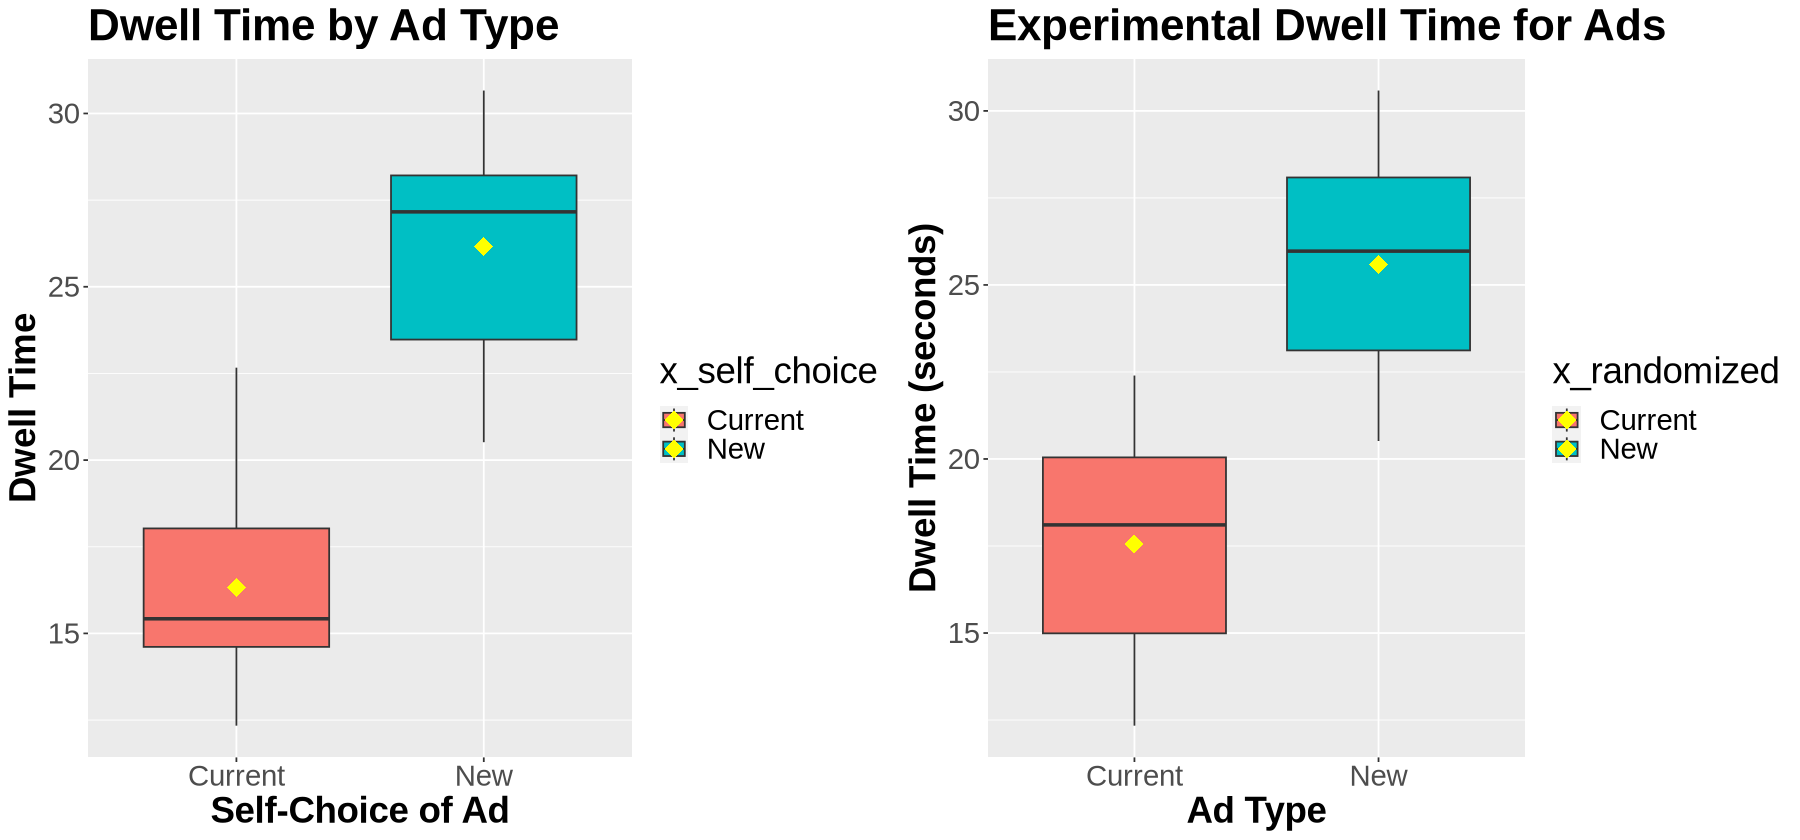

In [45]:
# exp_dwell_time_boxplots <- ... %>%
#   ggplot() +
#   ...(aes(..., ..., fill = ...)) +
#   theme(
#     text = element_text(size = 22),
#     plot.title = element_text(face = "bold"),
#     axis.title = element_text(face = "bold")
#   ) +
#   ggtitle(...) +
#   xlab(...) +
#   ylab(...) +
#   stat_summary(aes(..., ..., fill = ...),
#     fun = ..., colour = "yellow", geom = "point",
#     shape = 18, size = 5
#   )
# plot_grid(obs_dwell_time_boxplots, exp_dwell_time_boxplots)

# your code here
exp_dwell_time_boxplots <- sample_TikTok %>%
  ggplot() +
  geom_boxplot(aes(x = x_randomized, y = y_exp, fill = x_randomized)) +
  theme(
    text = element_text(size = 22),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) +
  ggtitle("Experimental Dwell Time for Ads") +
  xlab("Ad Type") +
  ylab("Dwell Time (seconds)") +
  stat_summary(aes(x = x_randomized, y = y_exp, fill = x_randomized),
    fun = mean, colour = "yellow", geom = "point",
    shape = 18, size = 5
  )
plot_grid(obs_dwell_time_boxplots, exp_dwell_time_boxplots)

In [46]:
test_2.12()

Test passed 😸
Test passed 😸
Test passed 🌈
Test passed 🥇
Test passed 🎉
Test passed 😸
Test passed 🥇
Test passed 😸
[1] "Success!"


**Question 2.13**
<br>{points: 1}

Using this new simulated dataset, estimate the linear regression of the experimental dwell time (`y_exp`) versus the assigned type of ad (`x_randomized`), and call it `exp_study_TikTok`. 

Report the estimated coefficients, their standard errors, and corresponding $p$-values using `tidy()`. Include the corresponding asymptotic 95% confidence intervals. Store the results in the variable `exp_study_TikTok_results`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [47]:
# exp_study_TikTok <- ...(...,
#   ...
# )
# exp_study_TikTok

# exp_study_TikTok_results <- ...(..., ...) %>% mutate_if(is.numeric, round, 2)
# exp_study_TikTok_results

# your code here
exp_study_TikTok <- lm(y_exp ~ x_randomized,
  data = sample_TikTok
)
exp_study_TikTok

exp_study_TikTok_results <- tidy(exp_study_TikTok, conf.int = 0.95) %>% mutate_if(is.numeric, round, 2)
exp_study_TikTok_results


Call:
lm(formula = y_exp ~ x_randomized, data = sample_TikTok)

Coefficients:
    (Intercept)  x_randomizedNew  
         17.559            8.024  


term            estimate std.error statistic p.value conf.low conf.high
1 (Intercept)     17.56    0.12      145.88    0       17.32    17.79    
2 x_randomizedNew  8.02    0.17       47.14    0        7.69     8.36

In [48]:
test_2.13()

Test passed 😀
Test passed 😀
Test passed 🌈
Test passed 🎉
Test passed 😀
Test passed 😸
Test passed 🌈
Test passed 😀
Test passed 🥇
Test passed 🥇
[1] "Success!"


**Question 2.14**
<br>{points: 1}

Based on your output in `exp_study_TikTok_results`, coming from the experimental study, what can we conclude on the estimation of the population effect of the new ad?


**A.** The estimated effect in dwell time when switching from the new to the current ad increases by 8.02 seconds. A randomized experiment provides an accurate effect estimate without including additional variables in the model.

**B.** The estimated effect in dwell time when switching from the current to the new ad increases by 8.02 seconds. A randomized experiment provides an accurate effect estimate without including additional variables in the model.

**C.** The estimated effect in dwell time when switching from the new to the current ad increases by 8.02 seconds. The effect is largely overestimated in this analysis.

**D.** The estimated effect in dwell time when switching from the current to the new ad increases by 8.02 seconds. The effect is largely underestimated in this analysis.

*Assign your answer to an object called `answer2.14`. Your answer should be one of `"A"`, `"B"`, `"C"`, or `"D"` surrounded by quotes.*

In [49]:
# answer2.14 <- 

# your code here
answer2.14 <- "B"

In [50]:
test_2.14()

Test passed 😸
Test passed 🌈
Test passed 🌈
[1] "Success!"


**Question 2.15**
<br>{points: 1}

Make a summary (it can be bullet points) of what you have learned from the simulation study in Section 2

> *Your answer goes here.*

*   It's important in statistical inference and data analysis to consider all possible confounding variables.
*   The simulation demonstrated that regression results based solely on treatment time can be confounded if variables are omitted.
*   The process of model reduction of multicollinearity and improve model interpretability by removing variables with VIF
*   The role of confounding variables in causal inference and how they can be biased from the results of a study if not properly accounted for
*   The importance of model diagnostics and validation to ensure that the assumptions of the regression model are met